In [1]:
import pandas as pd
import numpy as np
import re
%pip install matplotlib
from matplotlib import pyplot as plt
import datetime as dt
%pip install scipy
from scipy.stats import linregress
import numbers


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [136]:
def read_file(file_name):
    data = pd.read_csv(file_name)
    data['created_at'] = pd.to_datetime(data['created_at'], format="ISO8601", utc=True).dt.tz_localize(None)
    return data

In [137]:
dog_rates = read_file("dog_rates_tweets.csv")
dog_rates['created_at']

0       2018-05-10 20:36:44
1       2018-05-09 23:54:02
2       2018-05-09 23:48:56
3       2018-05-09 22:02:03
4       2018-05-09 01:19:40
                ...        
14923   2020-06-16 22:31:29
14924   2020-06-16 22:30:52
14925   2020-06-16 22:28:17
14926   2020-06-16 17:03:27
14927   2020-06-16 05:25:37
Name: created_at, Length: 14928, dtype: datetime64[ns]

In [138]:
def tweet_to_rating(tweet):
    """
    Args:
        tweet: a string that optionally contains a rating of the form x/10, where x is a positive integer

    Returns: NAN if the tweet has no rating, otherwise returns the numerical value of the rating
    """
    match = re.search(r'(\d+(?:\.\d+)?)/10', tweet)
    value = match and float(match.groups()[0])
    if isinstance(value, numbers.Number) and value <= 25.0: return value

def dates_and_ratings_of_valid_tweets(tweets):
    """
    Args:
        tweets: a DataFrame where each row contains the date a tweet was sent, the user who made
        the tweet, and the content of the tweet

    Returns: a DataFrame where each row has a date and rating of a tweet 
    corresponding to that date which contains a rating of the form x/10, 
    where x is in [0, 25]
    """
    return tweets.assign(rating=tweets['text'].apply(tweet_to_rating)).dropna()
    

In [139]:
tweets_with_valid_ratings = dates_and_ratings_of_valid_tweets(dog_rates)
ratings = tweets_with_valid_ratings['rating']
dates = tweets_with_valid_ratings['created_at']
tweets_with_valid_ratings

,id,created_at,text,rating
2,994363623421153280,2018-05-09 23:48:56,This is Louie. He has misplaced his Cheerio. W...,14.0
7,993889039714578432,2018-05-08 16:23:07,This is Manny. He hasn’t seen your croissant. ...,13.0
8,993629544463642624,2018-05-07 23:11:58,This is Libby. She leap. 14/10\r\n(IG: libbyth...,14.0
24,992198572664860672,2018-05-04 00:25:48,This is Rosie. She thought Coachella was this ...,13.0
30,991744041351090177,2018-05-02 18:19:39,This is Riley. He’ll be your chauffeur this ev...,13.0
...,...,...,...,...
14885,1275493485085245440,2020-06-23 18:18:39,This is Ruth. She was spotted at a rally doing...,14.0
14895,1275102054608855040,2020-06-22 16:23:14,This is Narcos. He is very angry with you. The...,13.0
14896,1274821722584125442,2020-06-21 21:49:18,@PatrickKenneyMD omg i’d say 13/10 but i’d hat...,13.0
14906,1273774320519483392,2020-06-19 00:27:18,This is Oakley. He’s on his way home for the f...,12.0


In [145]:
def slope_intercept_and_pvalue_of_best_fit_line(x_cors, y_cors):
    regress_info = linregress(x_cors, y_cors)
    return regress_info.slope, regress_info.intercept, regress_info.pvalue

to_seconds = lambda x: x.timestamp()
slope, intercept, pvalue = slope_intercept_and_pvalue_of_best_fit_line(dates.apply(to_seconds), ratings)

In [146]:
def add_date_in_seconds_and_rating_prediction(df: pd.DataFrame, slope, intercept) -> pd.DataFrame:
    copy = df.copy()
    copy['timestamp'] = copy['created_at'].apply(to_seconds)
    copy['prediction'] = copy['timestamp'] * slope + intercept
    return copy

In [147]:
tweets_with_dates_in_seconds = add_date_in_seconds_and_rating_prediction(tweets_with_valid_ratings, slope, intercept)
tweets_with_dates_in_seconds

,id,created_at,text,rating,timestamp,prediction
2,994363623421153280,2018-05-09 23:48:56,This is Louie. He has misplaced his Cheerio. W...,14.0,1.525910e+09,12.303448
7,993889039714578432,2018-05-08 16:23:07,This is Manny. He hasn’t seen your croissant. ...,13.0,1.525797e+09,12.301750
8,993629544463642624,2018-05-07 23:11:58,This is Libby. She leap. 14/10\r\n(IG: libbyth...,14.0,1.525735e+09,12.300822
24,992198572664860672,2018-05-04 00:25:48,This is Rosie. She thought Coachella was this ...,13.0,1.525394e+09,12.295704
30,991744041351090177,2018-05-02 18:19:39,This is Riley. He’ll be your chauffeur this ev...,13.0,1.525285e+09,12.294079
...,...,...,...,...,...,...
14885,1275493485085245440,2020-06-23 18:18:39,This is Ruth. She was spotted at a rally doing...,14.0,1.592936e+09,13.308880
14895,1275102054608855040,2020-06-22 16:23:14,This is Narcos. He is very angry with you. The...,13.0,1.592843e+09,13.307480
14896,1274821722584125442,2020-06-21 21:49:18,@PatrickKenneyMD omg i’d say 13/10 but i’d hat...,13.0,1.592776e+09,13.306478
14906,1273774320519483392,2020-06-19 00:27:18,This is Oakley. He’s on his way home for the f...,12.0,1.592526e+09,13.302732


In [148]:
slope, intercept

(np.float64(1.5000503986105543e-08), np.float64(-10.585967528906664))

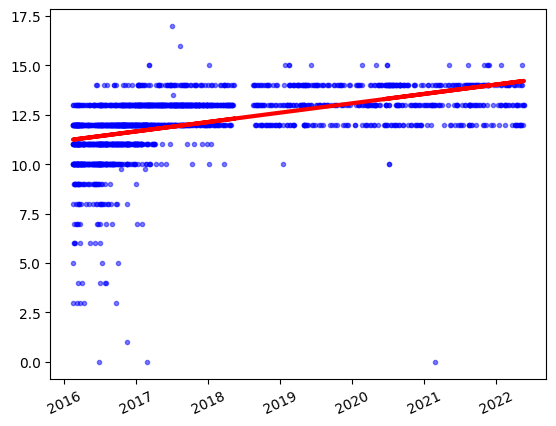

In [149]:
plt.xticks(rotation=25)
plt.plot(dates, ratings, 'b.', alpha=0.5)
plt.plot(dates, tweets_with_dates_in_seconds['timestamp'] * slope + intercept, 'r-', linewidth=3)

In [150]:
pvalue

np.float64(2.6070388139659223e-127)

(array([1.000e+00, 3.000e+00, 5.000e+00, 8.000e+00, 1.800e+01, 3.900e+01,
        5.280e+02, 1.291e+03, 2.190e+02, 4.000e+00]),
 array([-13.62907594, -11.75619624,  -9.88331654,  -8.01043685,
         -6.13755715,  -4.26467745,  -2.39179775,  -0.51891805,
          1.35396165,   3.22684134,   5.09972104]),
 <BarContainer object of 10 artists>)

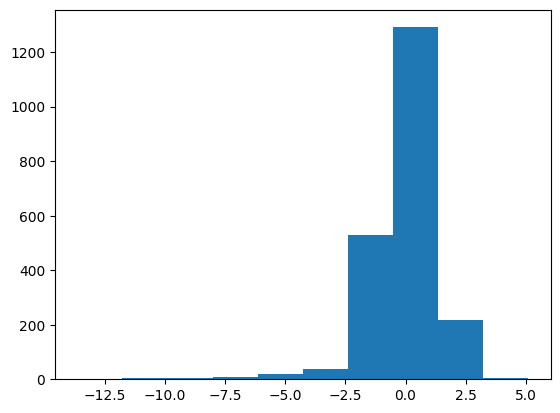

In [158]:
residuals = ratings - (tweets_with_dates_in_seconds['timestamp'] * slope + intercept)
plt.hist(residuals)